In [1]:

Patient = "P034" #"P015/P015_S01_D2024-07-06"
run = "S01"
date = "2025-05-22"

2025-06-27 17:47:05,614 - INFO - Using device: mps
2025-06-27 17:47:06,274 - INFO - Loaded primary TDMS file: Data/P034/P034_S01_D2025-05-22.tdms
2025-06-27 17:47:06,538 - INFO - Loaded additional TDMS file: Data/P034/P034_S01_D2025-05-22_addCh.tdms
2025-06-27 17:47:06,540 - INFO - Loaded sensor log file: Data/P034/QZFM_log_file.txt
2025-06-27 17:47:06,540 - INFO - Available runs: Bauchlage, Rueckenlage, R003
2025-06-27 17:47:07,014 - INFO - Model loaded from MCG_segmentation/trained_models/UNet_1D_15M/checkpoints/best_2/model.pth


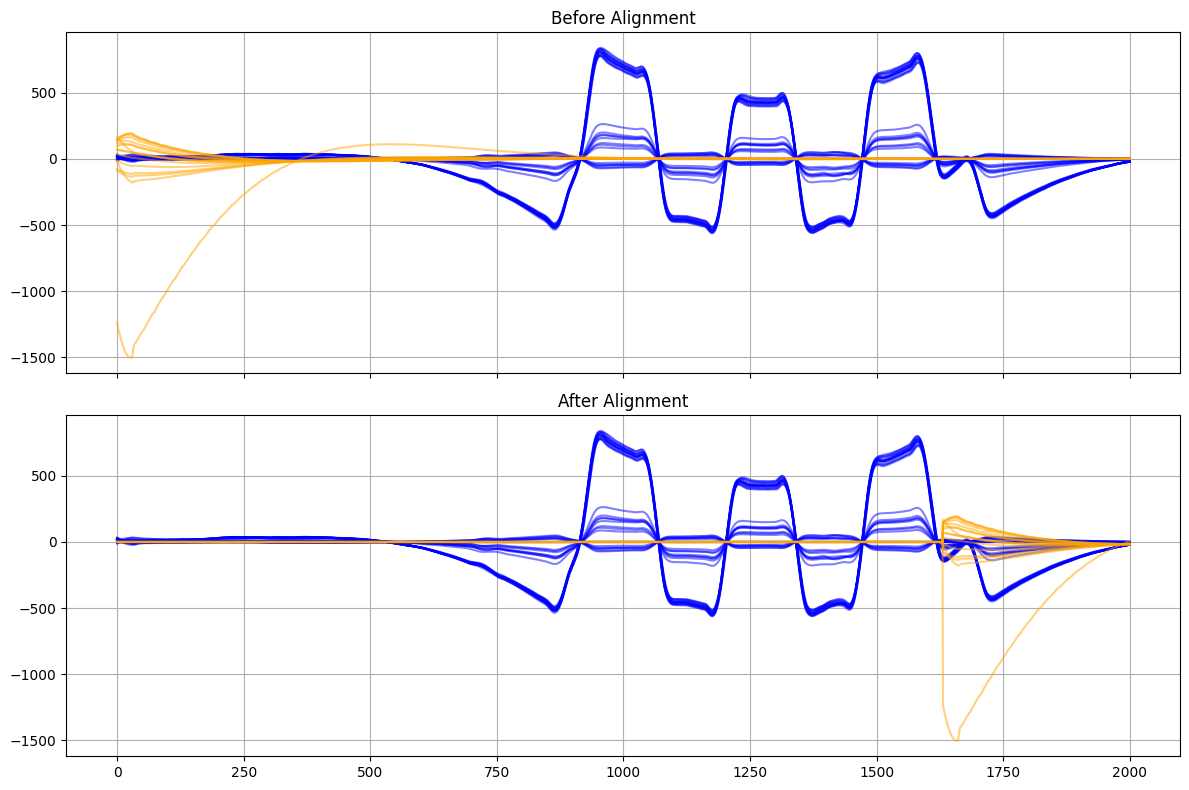

2025-06-27 17:47:08,958 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 73148, Original length: 292592 samples.


In [3]:
import importlib
import analyzer
importlib.reload(analyzer)
from analyzer import Analyzer
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import json
import numpy as np




analysis = Analyzer(
        filename=f"Data/{Patient}/{Patient}_{run}_D{date}.tdms",
        add_filename=f"Data/{Patient}/{Patient}_{run}_D{date}_addCh.tdms",
        log_file_path=f"Data/{Patient}/QZFM_log_file.txt",
        sensor_channels_to_exclude={"Bauchlage": ["NL_x", "OT_y", "OT_z", "OX_x", "OX_y"]},
        model_checkpoint_dir=f"MCG_segmentation/trained_models/UNet_1D_15M",
    )

key = "Bauchlage"
(x_data, y_data, z_data), time, single_run = analysis.prepare_data(key, apply_default_filter=True, plot_alignment=True)


# Find fitting intervall

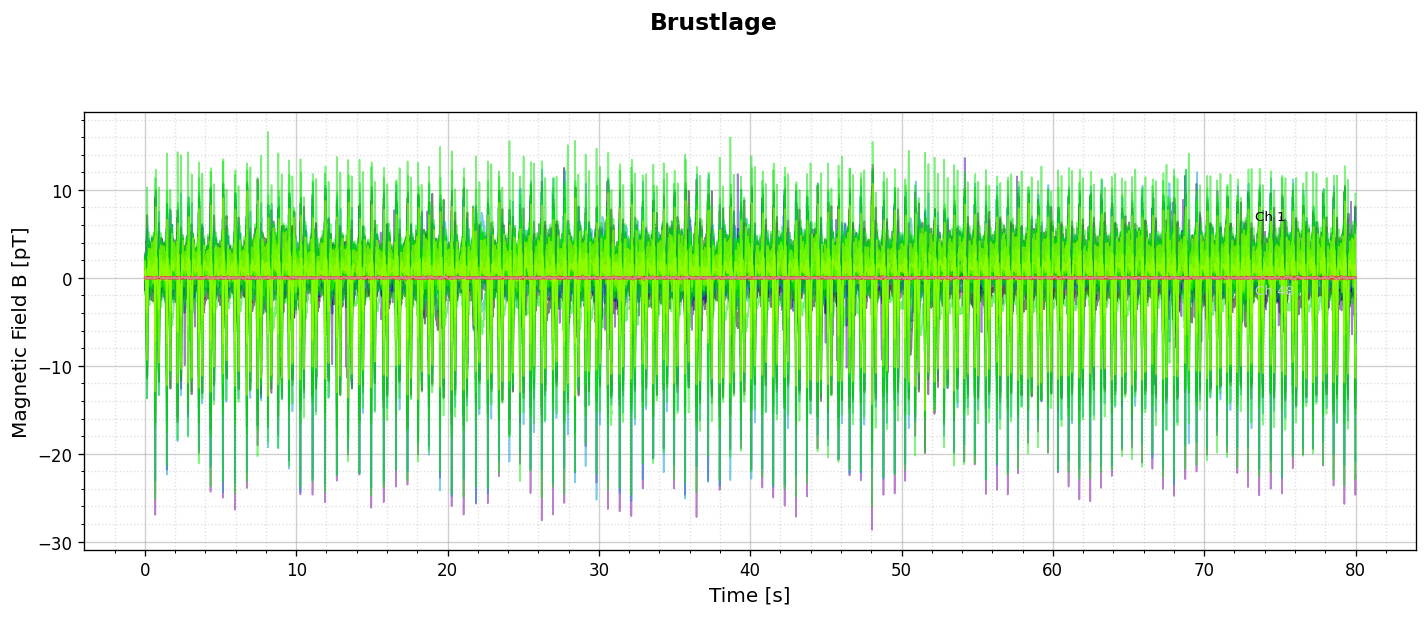

In [4]:
intervall_start = 0
intervall_end = 20000


analysis.butterfly_plot(single_run[: :, intervall_start:intervall_end], time[intervall_start:intervall_end], single_run.shape[0], "Brustlage")

## Apply ICA filtering 

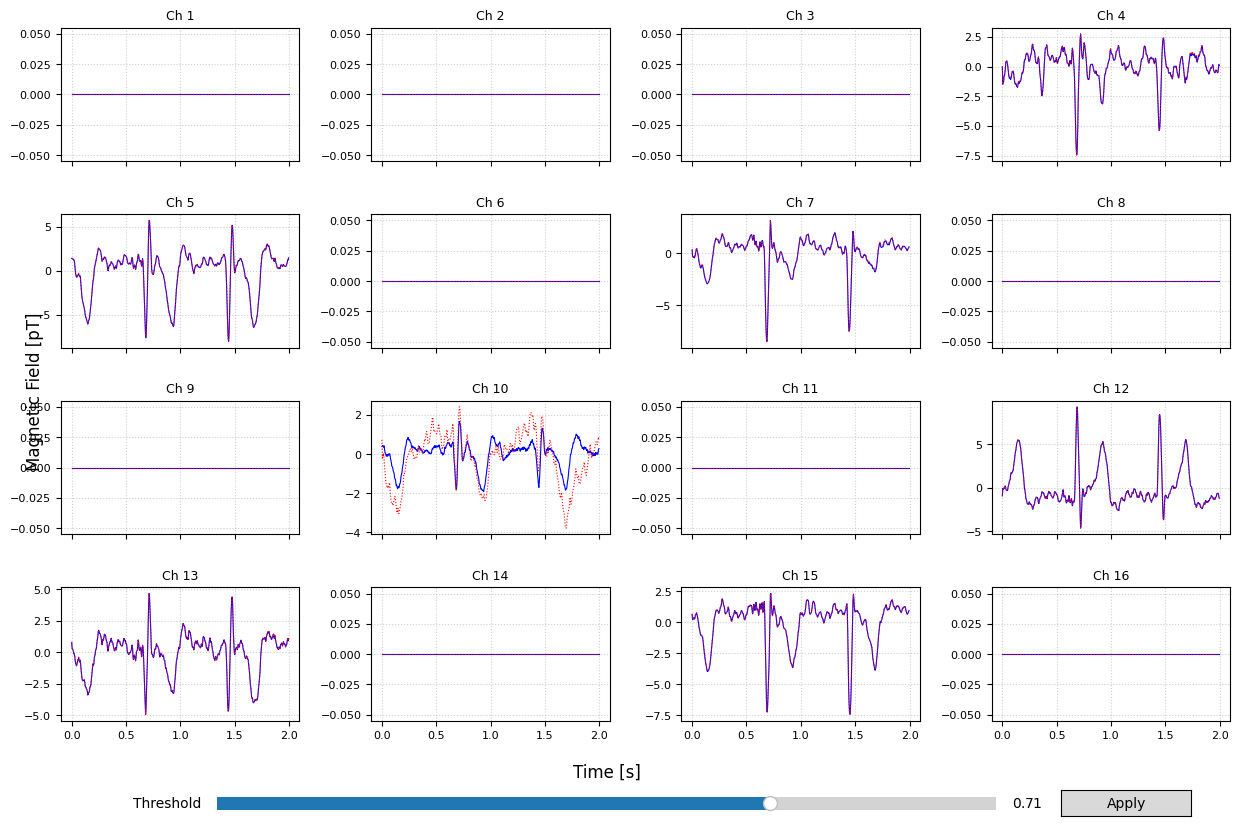

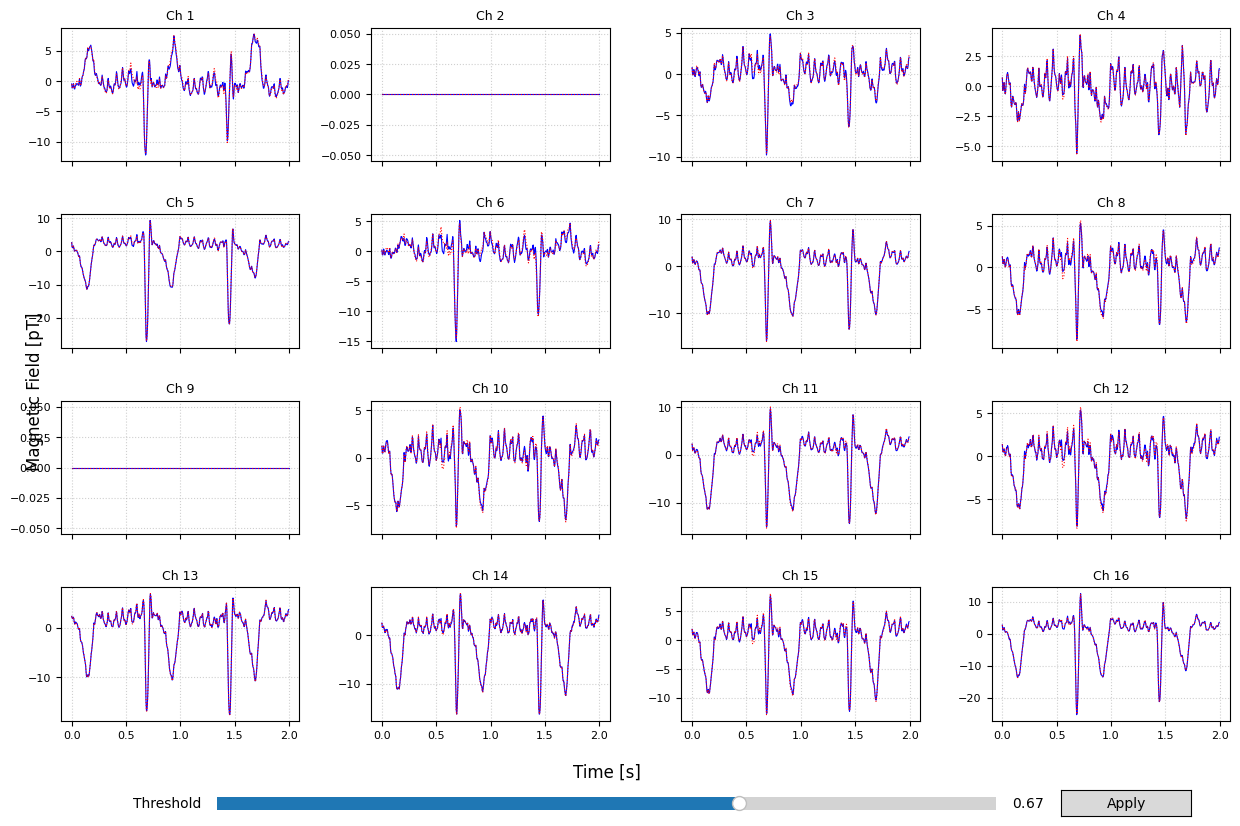

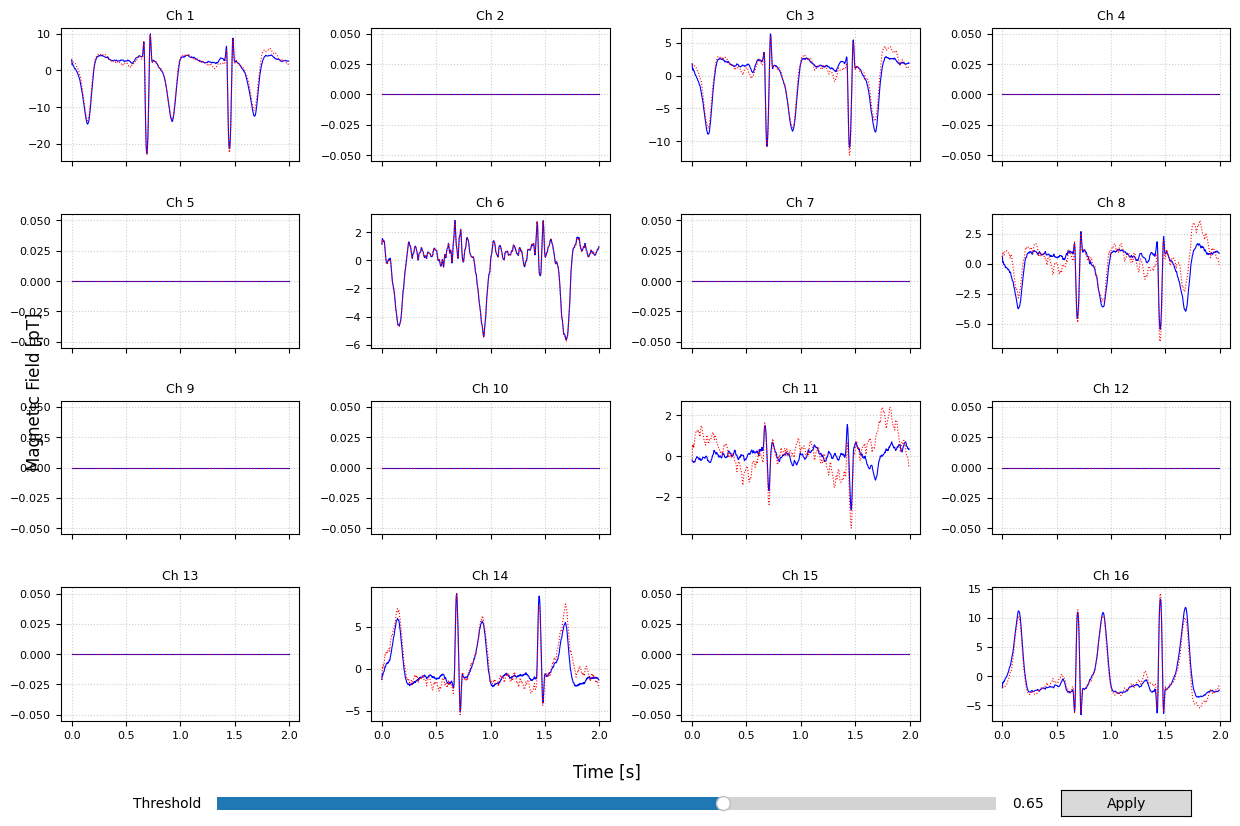

In [ ]:


x_data_intervall = x_data[:, :, intervall_start:intervall_end]
y_data_intervall = y_data[:, :, intervall_start:intervall_end]
z_data_intervall = z_data[:, :, intervall_start:intervall_end]
time_intervall = time[intervall_start:intervall_end]
single_run_intervall = single_run[:, intervall_start:intervall_end]


#analysis.plot4x4(z_data[:, :, 250:1250], time[250:1250], name="z_data")

x_data_filtered, _, _, _ = analysis.ICA_filter(x_data_intervall, heart_beat_score_threshold=0.71, plot_result=True)
y_data_filtered, ica_components, _, _ = analysis.ICA_filter(y_data_intervall, heart_beat_score_threshold=0.69, plot_result=True)
z_data_filtered, _, _, _ = analysis.ICA_filter(z_data_intervall, heart_beat_score_threshold=0.65, plot_result=True)

#print(ica_components.shape)
#analysis.plot_sensor_matrix(ica_components[:, :500].reshape(4, 4, -1), time_intervall[:500], name="ica_components")

Improve Windowing

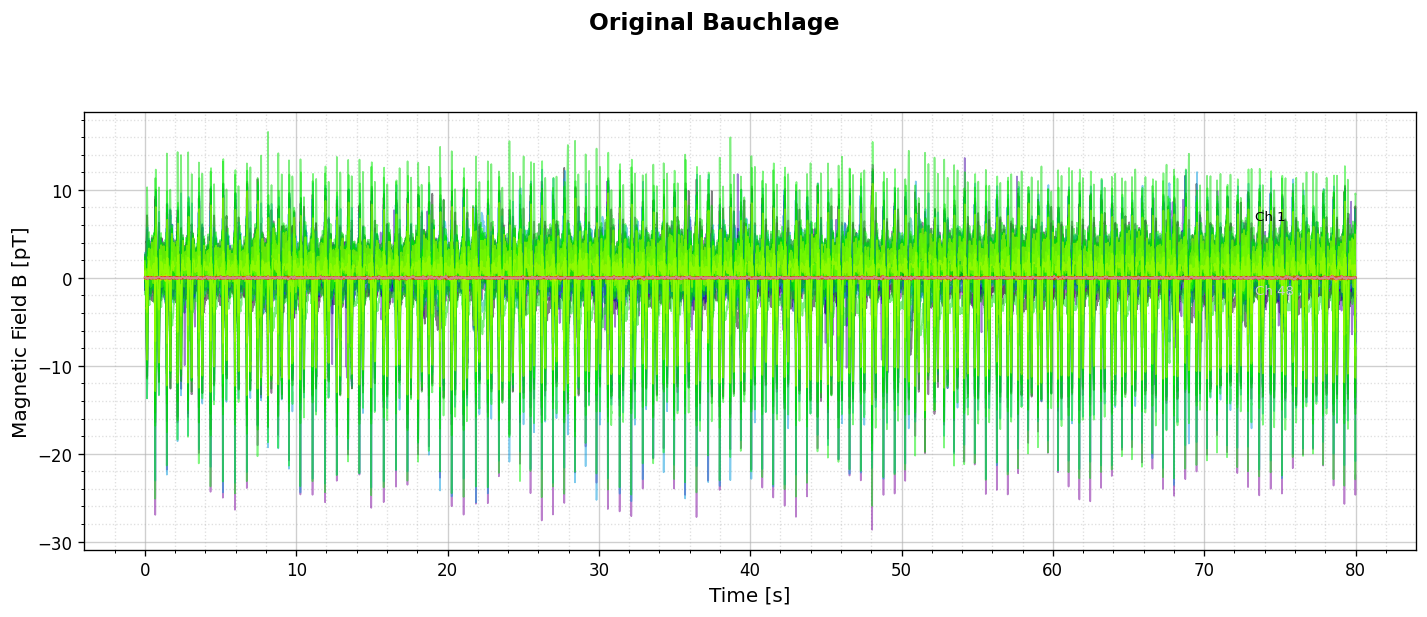


Channel Selection Results:
Channel   Conf        P-Wave %    QRS %       T-Wave %    Plausibility   Final Score 
-------------------------------------------------------------------------------------
1         0.8031      13.18       16.16       25.92       0.8957         0.8216      
2         0.8310      6.36        16.55       25.60       0.7582         0.8164      
3         0.8087      15.21       16.38       25.86       0.8632         0.8196      
4         0.8029      5.67        17.94       23.56       0.6553         0.7734      
5         0.8198      9.50        17.25       24.92       0.8163         0.8191      
6         0.8553      0.07        15.21       25.05       0.5511         0.7945      
7         0.7527      0.10        18.59       14.16       0.4477         0.6917      
8         0.7754      0.00        10.32       6.35        0.3752         0.6953      
9         0.8151      0.00        6.37        0.10        0.2896         0.7100      
10        0.8127      0.00

2025-06-27 17:48:47,477 - INFO - Heart Rate: 83.23 bpm
2025-06-27 17:48:47,483 - INFO - Heart Rate Variability (SDNN): 43.51 ms
2025-06-27 17:48:47,483 - INFO - Number of detected peaks: 110
2025-06-27 17:48:47,483 - INFO - Number of plausible RR intervals used: 109


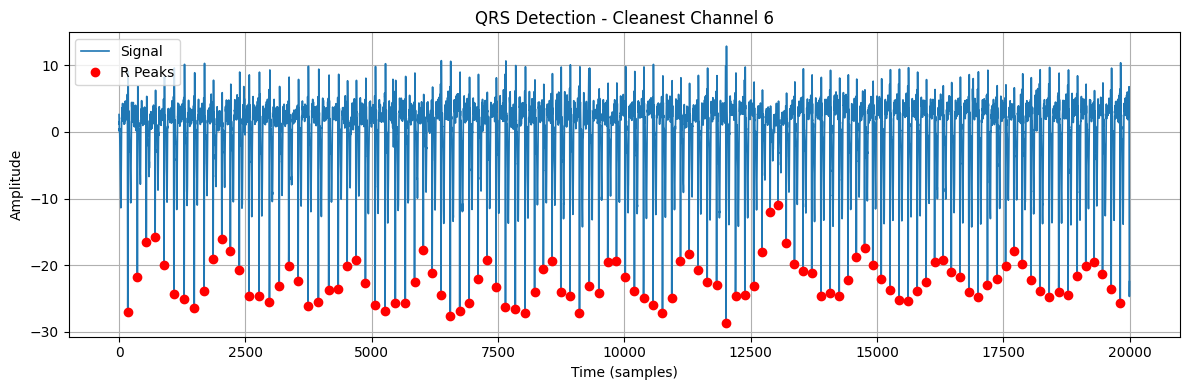

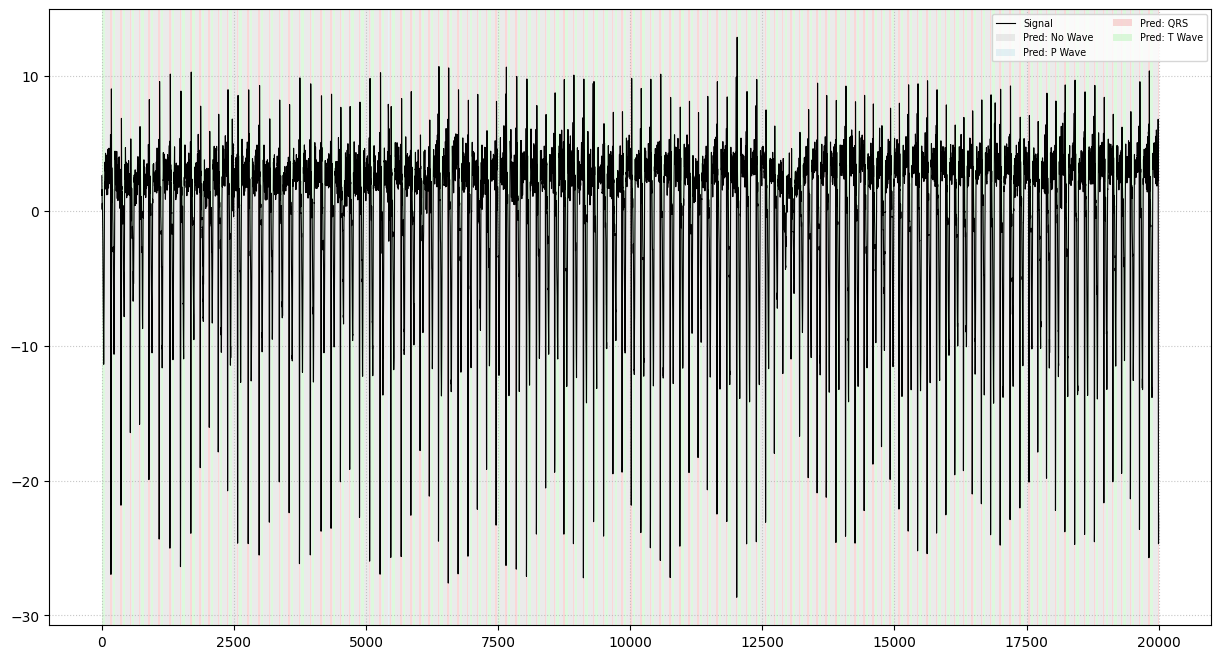

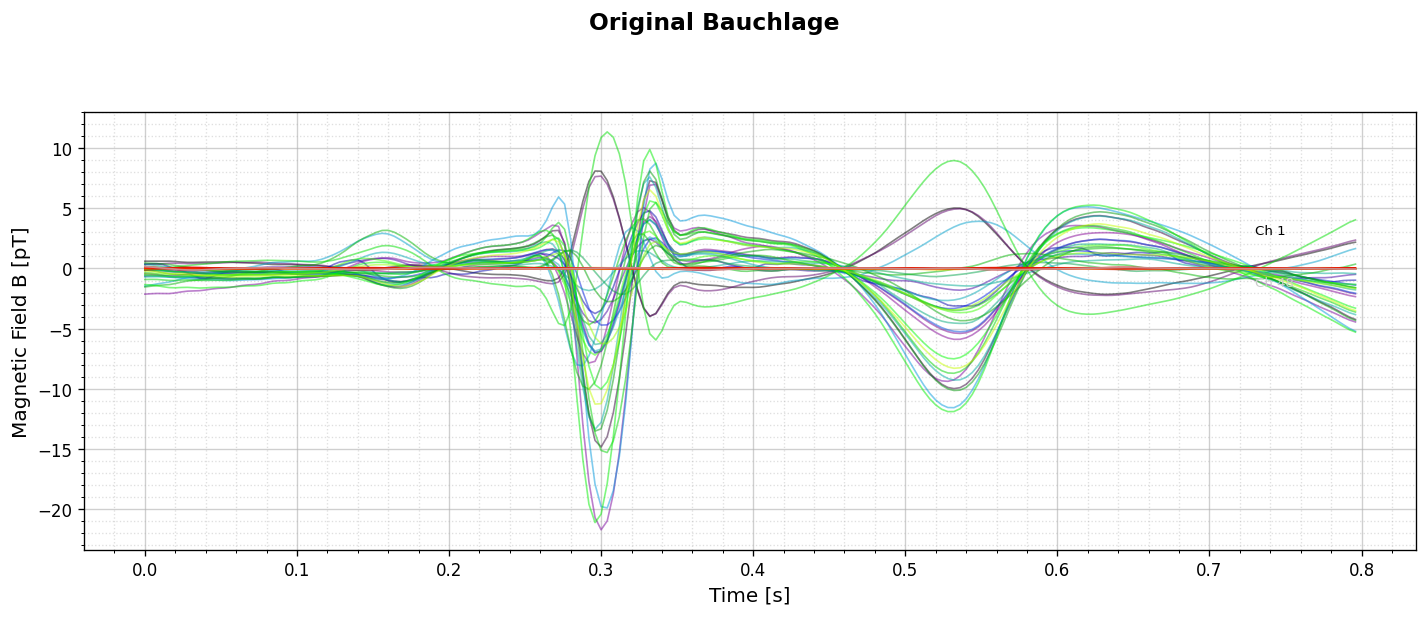

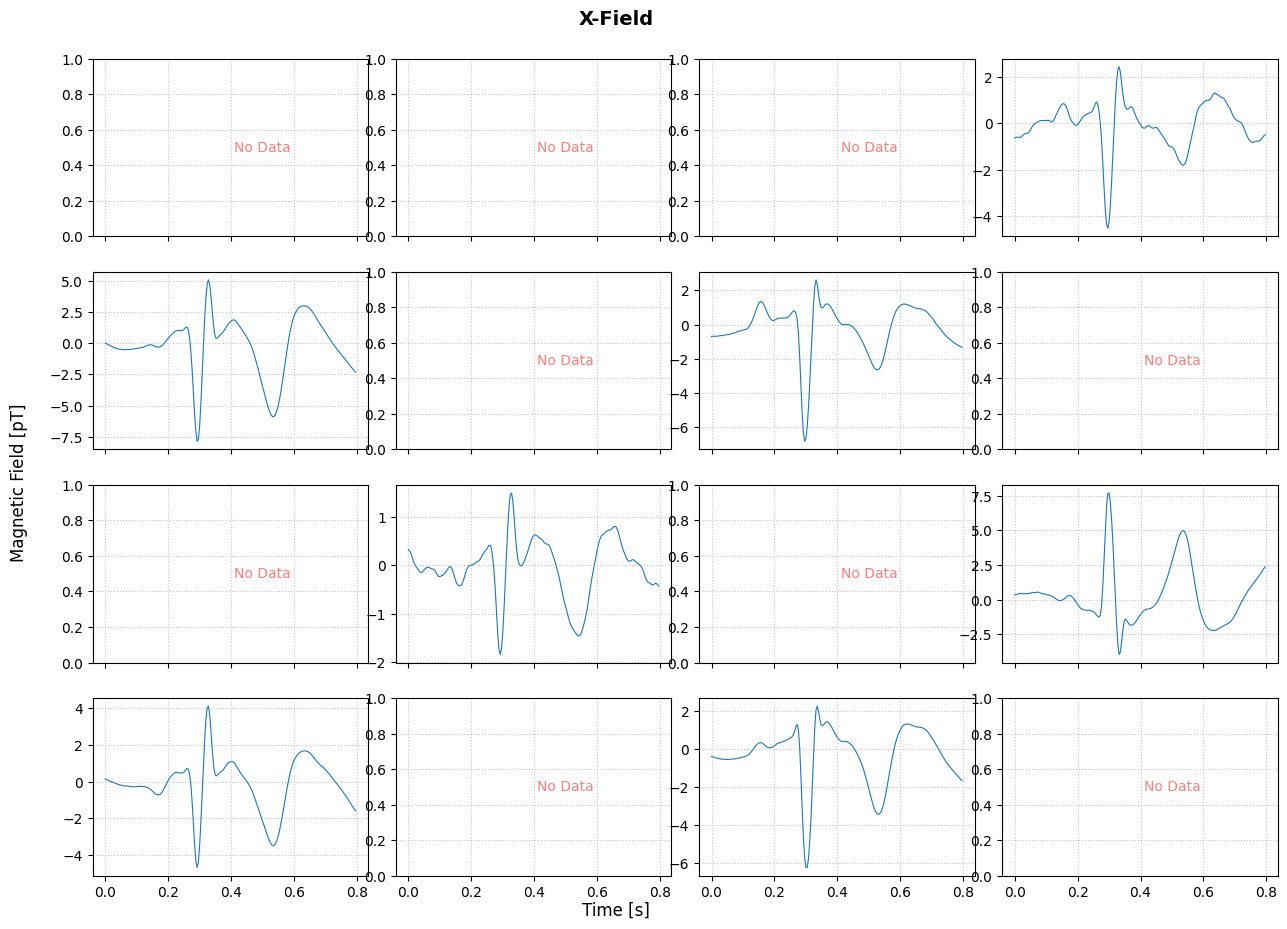

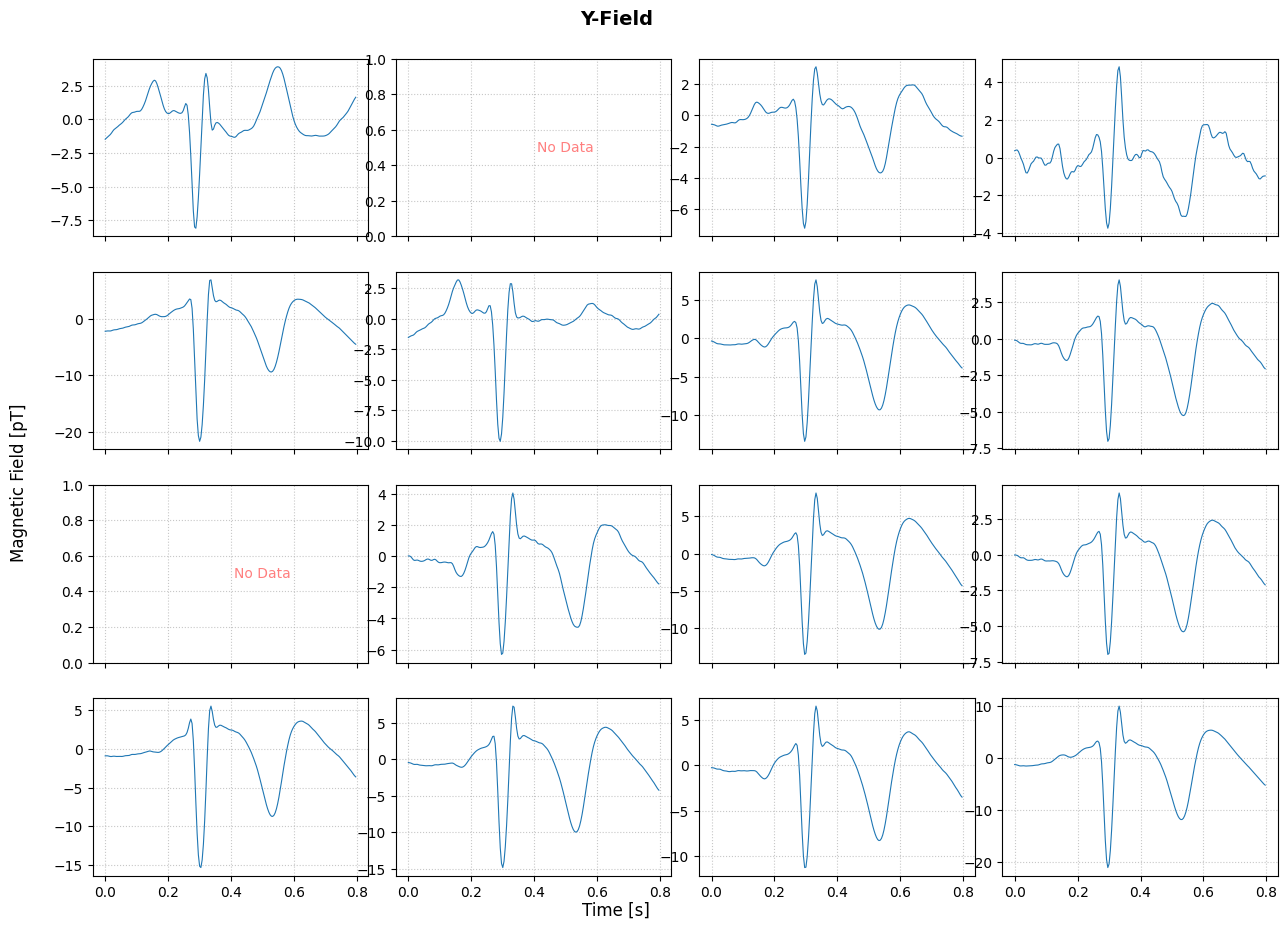

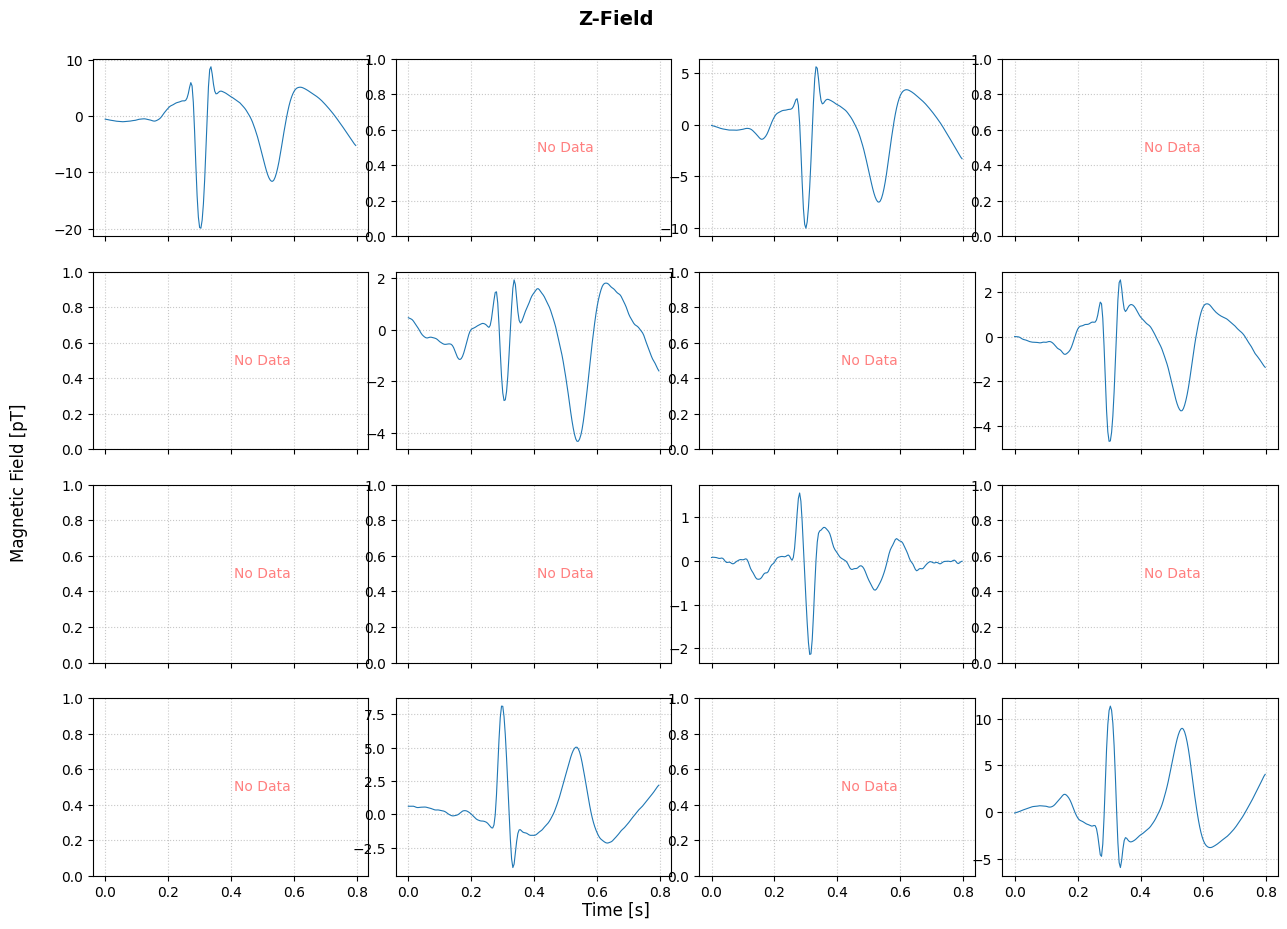

In [8]:
single_run_filtered = single_run_intervall#analysis.invert_field_directions(x_data_filtered, y_data_filtered, z_data_filtered, key, 48)


analysis.butterfly_plot(single_run_filtered, time_intervall, 48, f"Original {key}")


analysis.find_cleanest_channel(single_run_filtered)

# use cleanest channel for peak detection
peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run_filtered, print_heart_rate=True, confidence_threshold=0.7, confidence_weight=1, plausibility_weight=0)
if peak_positions is not None and len(peak_positions) > 0:
    plt.figure(figsize=(12, 4))
    plt.plot(single_run_filtered[ch, :], label='Signal', linewidth=1.2)
    #plt.plot(resampled_data[ch, :], label='Signal', linewidth=1.2)
    plt.plot(peak_positions, single_run_filtered[ch, peak_positions], "ro", markersize=6, label='R Peaks')
    plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No R peaks detected or `peak_positions` is empty.")
analysis.plot_segmented_signal(single_run_filtered[ch, :], labels[ch, :])


# window averaging
avg_channels, time_window = analysis.avg_window(single_run_filtered, peak_positions, window_left=0.3, window_right=0.5)
analysis.butterfly_plot(avg_channels, time_window, 48, f"Original {key}")


x_data_window, y_data_window, z_data_window = analysis.get_field_directions(avg_channels, key)

analysis.plot_sensor_matrix(x_data_window, time_window, name="X-Field")
analysis.plot_sensor_matrix(y_data_window, time_window, name="Y-Field")
analysis.plot_sensor_matrix(z_data_window, time_window, name="Z-Field")



## ICD Analysis

2025-06-21 13:13:20,115 - INFO - Loaded primary TDMS file: Data/P019/P019_S01_D2024-08-29.tdms
2025-06-21 13:13:20,408 - INFO - Loaded additional TDMS file: Data/P019/P019_S01_D2024-08-29_addCh.tdms
2025-06-21 13:13:20,410 - INFO - Loaded sensor log file: Data/P019/QZFM_log_file.txt
2025-06-21 13:13:20,410 - INFO - Available runs: Brustlage, Rueckenlage, Noise
/Users/samuelfriese/Desktop/Bachelorarbeit/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-06-21 13:13:20,519 - INFO - Model loaded from MCG_segmentation/trained_models/MCGSegmentator_s/checkpoints/best/model.pth


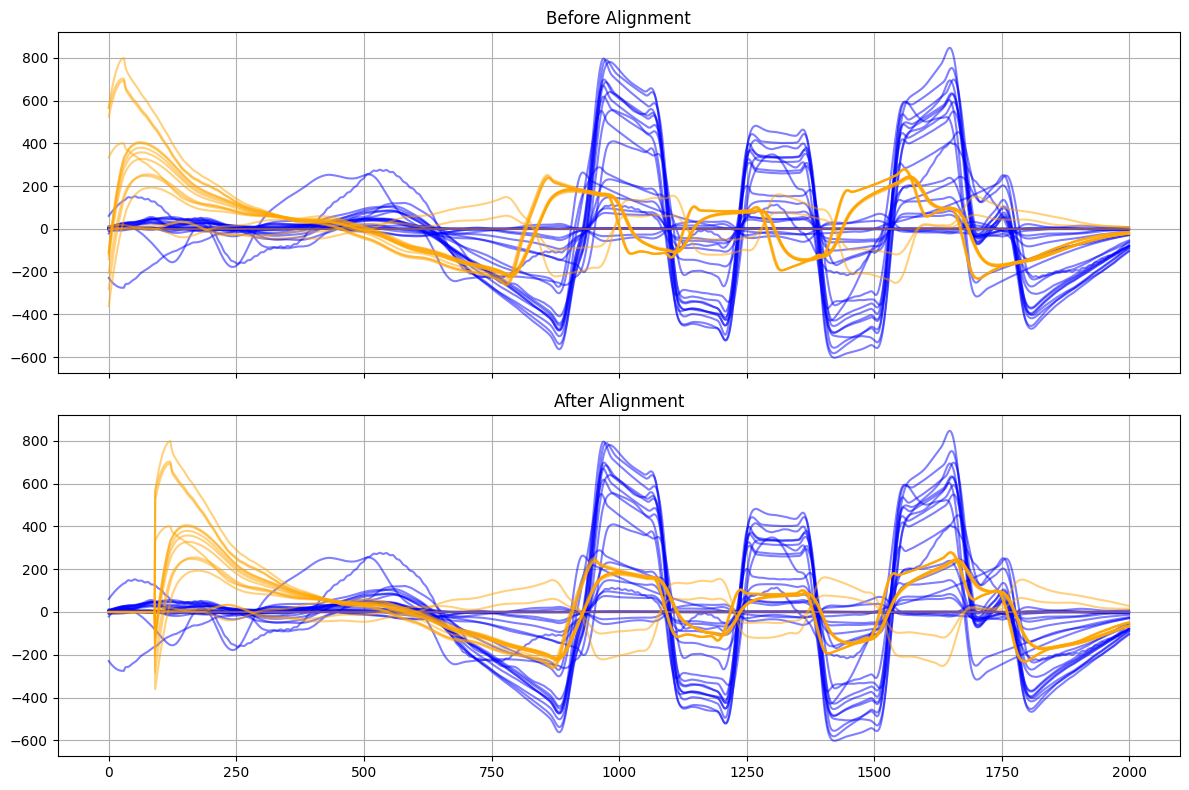

2025-06-21 13:13:22,299 - INFO - Resampling data from 1000Hz to 250Hz. Target length: 73042, Original length: 292171 samples.


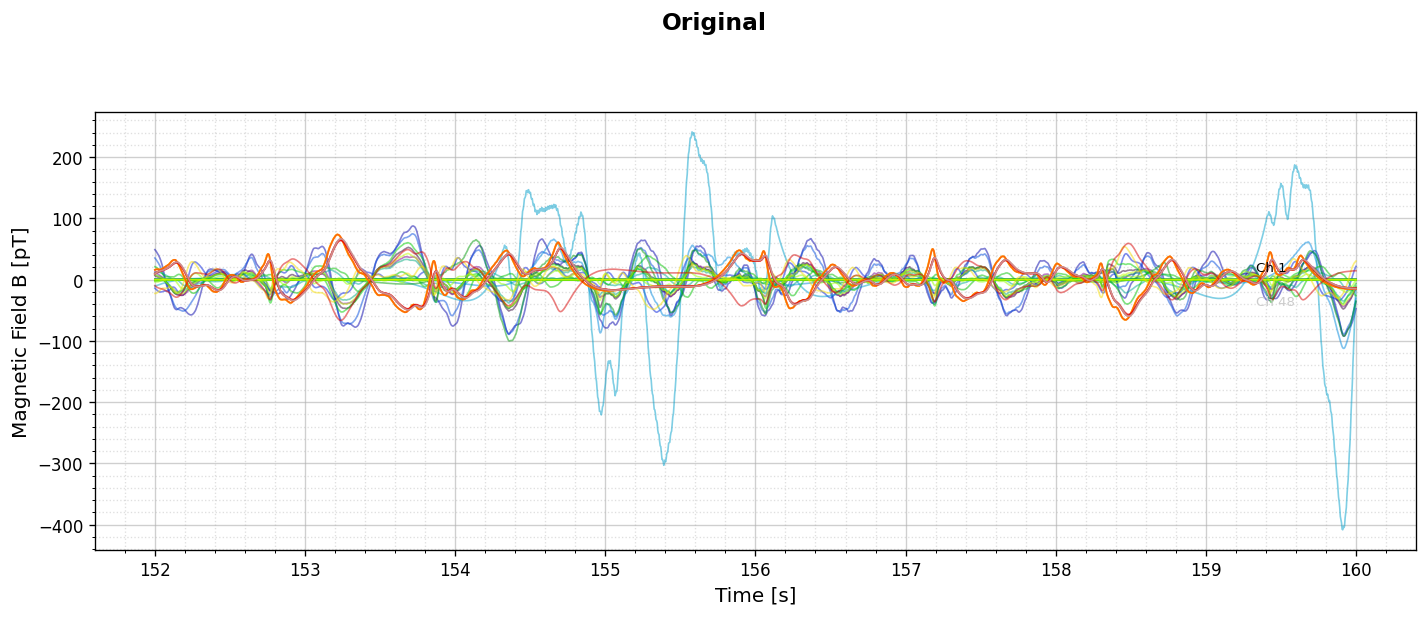

2025-06-21 13:13:24,582 - WARNING - No peaks detected.


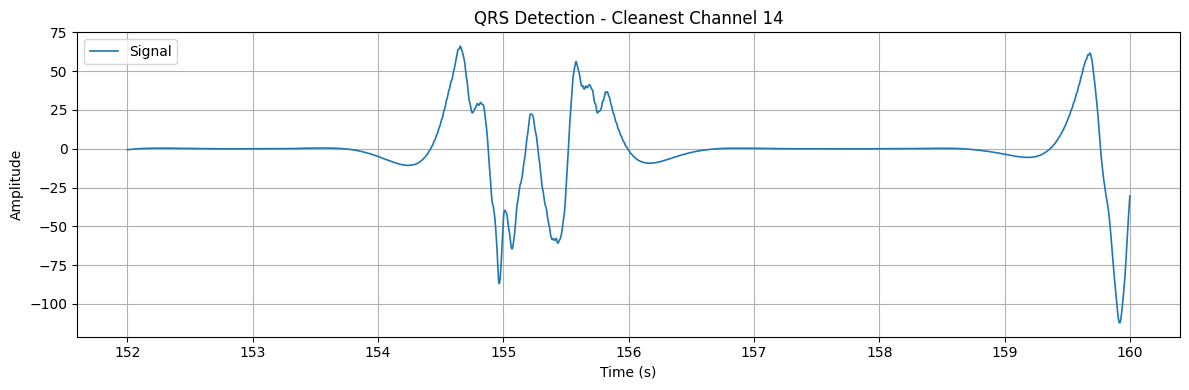

NameError: name 'avg_channels' is not defined

In [ ]:
patient = "P019" #"P015/P015_S01_D2024-07-06"
date = "2024-08-29"
run = "S01"

log_file_path = f"Data/{patient}/QZFM_log_file.txt"
add_filename = f"Data/{patient}/{patient}_{run}_D{date}_addCh.tdms"
file_name = f"Data/{patient}/{patient}_{run}_D{date}.tdms"

analysis = Analyzer(
        filename=file_name,
        add_filename=add_filename,
        log_file_path=log_file_path,
        model_checkpoint_dir="MCG_segmentation/trained_models/MCGSegmentator_s",
        sensor_channels_to_exclude={}
    )

(x_data, y_data, z_data), time, single_run = analysis.prepare_data("Brustlage", apply_default_filter=True, plot_alignment=True)

single_run = single_run[:, 38000:40000]
time = time[38000:40000]

analysis.butterfly_plot(single_run, time, 48, f"Original")

peak_positions, ch, labels, _, _ = analysis.detect_qrs_complex_peaks_cleanest_channel(single_run, print_heart_rate=True, confidence_threshold=0.7)

plt.figure(figsize=(12, 4))
plt.plot(time, single_run[ch, :], label='Signal', linewidth=1.2)
plt.title(f"QRS Detection - Cleanest Channel {ch + 1}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


if peak_positions is not None and len(peak_positions) > 0:
    # window averaging
    avg_channels, time_window = analysis.avg_window(single_run, peak_positions, window_left=0.3, window_right=0.5)
    analysis.butterfly_plot(avg_channels, time_window, 48, f"Original")


# Example: Apply LSD plotting to QRS-aligned average data
channels_to_plot = list(range(avg_channels.shape[0]))  # or a subset if too many

# Create dummy noise_theos (or load actual theoretical noise floor if available)
noise_theos = [1.0] * len(channels_to_plot)  # Replace with real values if you have them


# Call your function
analysis.plot_lsd_multichannel(
    data=avg_channels,
    noise_theos=noise_theos,
    channels=channels_to_plot,
)

